In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

1. General info about the dataset: number of ratings, users, books
2. Average number of ratings per book, per user + distribution
3. Distribution of scores of books
4. Joint plot (count & rating) of books - what are the scores of frequently scored books and rarely scored books
5. Number of books from each year & number of ratings (& avg score)
6. Average score and number of ratings of:
- top popular books
- best scored books
7. Average score and number of ratings of:
- top popular authors
- best scored authors



Preprocessing
* load data without skipping rows
* remove incorrect rows
* add missing isbns (scraper?)
* remove books older than around 1900

In [3]:
df = pd.read_csv('data/ratings_explicit.csv')

In [4]:
#df.columns = ['user_id', 'isbn', 'rating']
#df = df[df['rating']!=0] #remove implicit ratings
df.head()

,user_id,isbn,book_rating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276736,3257224281,8
4,276737,0600570967,6


In [5]:
print('Number of ratings: %d\nNumber of users: %d\nNumber of books: %d' % (len(df), len(df['user_id'].unique()), len(df['isbn'].unique())))

Number of ratings: 433642
Number of users: 77792
Number of books: 185946


In [6]:
def df_dist(df, colname, norm=False):
    new_df = df[colname].value_counts(normalize=norm).reset_index()
    new_df.columns = [colname, 'count']
    return new_df

In [7]:
dist_user = df_dist(df, 'user_id')
dist_book = df_dist(df, 'isbn')

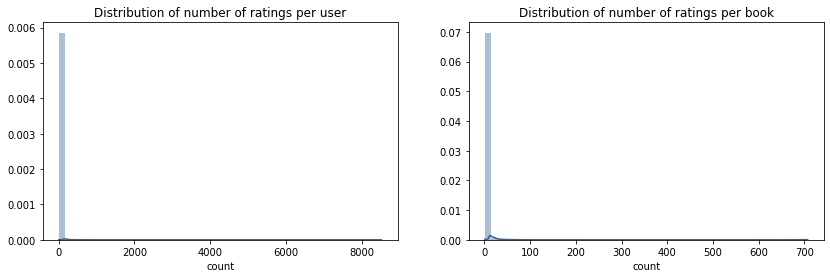

Average number of ratings per user: 5.57
Average number of ratings per book: 2.33


In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(dist_user['count'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of number of ratings per user')

sns.distplot(dist_book['count'], color='#2f6194', ax=ax2)
ax2.set_title('Distribution of number of ratings per book')

plt.show()

print('Average number of ratings per user: %.2f\nAverage number of ratings per book: %.2f' % (dist_user['count'].mean(), dist_book['count'].mean()))

In [9]:
user_threshold = 3
book_threshold = 0.05

user_list = dist_user[dist_user['count']>=user_threshold]['user_id'].unique()
df_top = df[df['user_id'].isin(user_list)]
print('number of users with more than %d ratings: %d' % (user_threshold, len(user_list)))
print('number of ratings', len(df_top))

dist_book2 = df_dist(df_top, 'isbn', norm=True)
book_list = dist_book2.head(int(book_threshold * len(dist_book2)))['isbn'].unique()
df_top = df_top[df_top['isbn'].isin(book_list)]

print('\nnumber of top %d%% most popular books: %d' % (book_threshold*100, len(book_list)))
print('number of ratings', len(df_top))

number of users with more than 3 ratings: 22567
number of ratings 368563

number of top 5% most popular books: 8383
number of ratings 138181


In [23]:
df_top.to_csv('data/ratings_top.csv', encoding='utf-8', index=False)

In [12]:
dist_rating = df_dist(df, 'book_rating')
dist_rating_top = df_dist(df_top, 'book_rating')

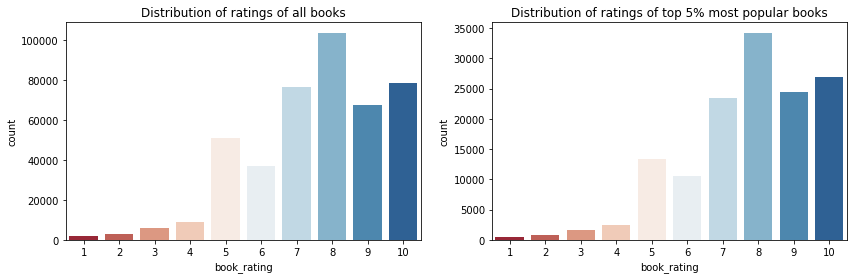

In [13]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.barplot(x='book_rating', y='count', data=dist_rating, palette=palette, ax=ax1)
ax1.set_title('Distribution of ratings of all books')

sns.barplot(x='book_rating', y='count', data=dist_rating_top, palette=palette, ax=ax2)
ax2.set_title('Distribution of ratings of top 5% most popular books')

plt.show()

In [14]:
books = df.groupby('isbn').agg({'book_rating': ['count', 'mean']}).reset_index()
books.columns  = ['isbn', 'count', 'rating']
books = books.sort_values(by='count', ascending=False)

In [15]:
df_books = pd.read_csv('data/books.csv')
#df_books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
#df_books.columns= ['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher']

In [16]:
books = books.merge(df_books, on='isbn', how='left')
books.head(2)

,isbn,count,rating,book_title,book_author,year_of_publication,publisher
0,0316666343,707,8.185290,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown"
1,0971880107,581,4.390706,Wild Animus,Rich Shapero,2004.0,Too Far


In [17]:
def short_title(title, max_len=40):
    title = str(title).split(' ')
    short_title = ''
    
    for i in range(len(title)):
        if len(short_title) < max_len:
            short_title = ' '.join([short_title, title[i]])
    short_title = short_title.strip()
    return short_title

In [18]:
books['book_title_short'] = books['book_title'].apply(short_title, max_len=35)

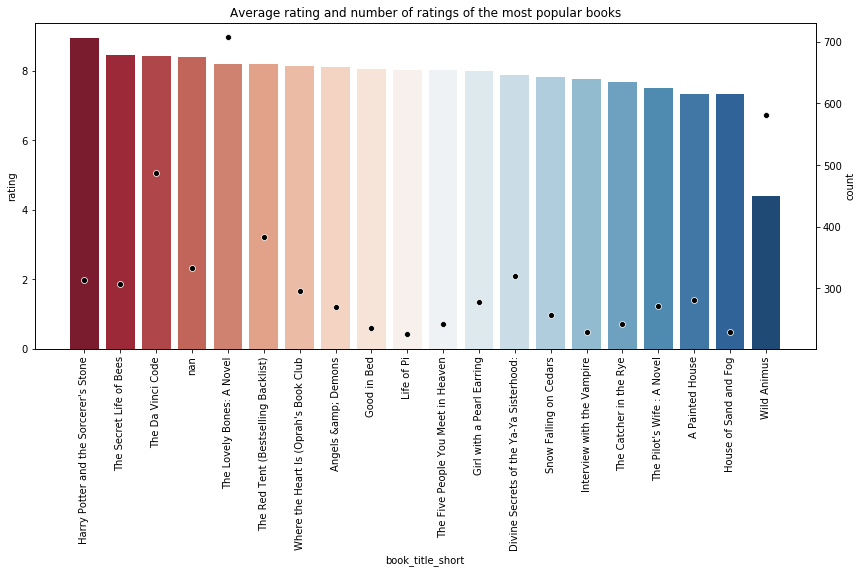

In [19]:
books_data = books.head(20)
books_data = books_data.sort_values(by='rating', ascending=False)

fig, ax1 = plt.subplots(figsize=(14, 6))
plt.xticks(rotation=90)

palette = sns.color_palette("RdBu", 20)

sns.barplot(x='book_title_short', y='rating', data=books_data, palette=palette, ax=ax1)
ax1.set_title('Average rating and number of ratings of the most popular books')

ax2 = ax1.twinx()
sns.scatterplot(x='book_title_short', y='count', data=books_data, color='black', ax=ax2)

plt.show()

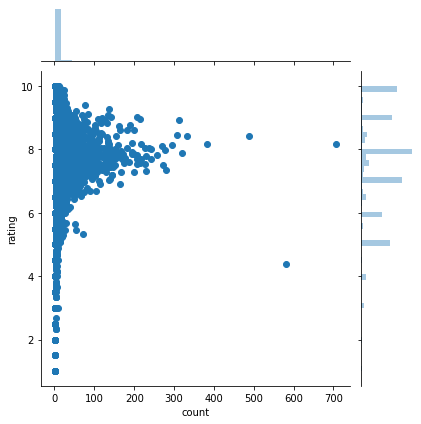

In [20]:
sns.jointplot(x='count', y='rating', data=books)

In [21]:
books_data.head()

,isbn,count,rating,book_title,book_author,year_of_publication,publisher,book_title_short
6,059035342X,313,8.939297,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999.0,Arthur A. Levine Books,Harry Potter and the Sorcerer's Stone
7,0142001740,307,8.452769,The Secret Life of Bees,Sue Monk Kidd,2003.0,Penguin Books,The Secret Life of Bees
2,0385504209,487,8.435318,The Da Vinci Code,Dan Brown,2003.0,Doubleday,The Da Vinci Code
4,0679781587,333,8.408408,NaN,NaN,NaN,NaN,nan
0,0316666343,707,8.185290,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",The Lovely Bones: A Novel


In [55]:
books.head(5).sort_values(by='rating', ascending=False)

,isbn,count,rating,book_title,book_author,year_of_publication,publisher,book_title_short
2,0385504209,487,8.435318,The Da Vinci Code,Dan Brown,2003,Doubleday,The Da Vinci Code
4,0679781587,333,8.408408,NaN,NaN,NaN,NaN,nan
0,0316666343,707,8.185290,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",The Lovely Bones: A Novel
3,0312195516,383,8.182768,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,The Red Tent (Bestselling Backlist)
1,0971880107,581,4.390706,Wild Animus,Rich Shapero,2004,Too Far,Wild Animus


In [77]:
def year(y):
    try:
        return int(y)
    except ValueError:
        return 0

df_books['year_of_publication'] = df_books['year_of_publication'].apply(year)

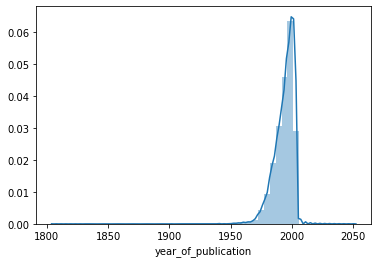

In [83]:
df_books_new = df_books[df_books['year_of_publication']>1800]
sns.distplot(df_books_new['year_of_publication'])

In [81]:
df_books[df_books['year_of_publication']<1900]['year_of_publication'].unique()

array([   0, 1806, 1378, 1897, 1376], dtype=int64)

In [87]:
df_books[df_books['year_of_publication'].between(1800,1900)]

,isbn,book_title,book_author,year_of_publication,publisher
108555,B0000VZEFK,Is That a Gun in Your Pocket?: Women's Experie...,Rachel Abramowitz,1900,Random House
171817,0781228956,"Complete Works 10 Volumes [2,6,7,8,9] (Notable...",Benjamin Franklin,1806,Reprint Services Corp
211854,1551103982,The Cycling Adventures of Coconut Head: A Nort...,Ted Schredd,1900,Graphic Arts Center Pub Co
245607,0781268001,"Hugh Wynne, Free Quaker (2 Volumes (BCL1-PS Am...",Silas Weir Mitchell,1897,Reprint Services Corp
256444,B00009NDBF,Help Yourself: Celebrating the Rewards of Resi...,David J. Pelzer,1900,E P Dutton
